# Final Project: Spotify API Data

## Introduction

For my Final Project, I intend on creating an IPython notebook from the “Top Hits Spotify from 2000-2019” dataset, made available on Kaggle by users rajattomar132, Shreyas Daniel Gaddam, and Juan Ignacio Hernández. The dataset contains the 1800 of most played songs released between 1998-2020, on the popular music streaming platform Spotify. Spotify provides popularity information for each of the songs in its library, categorical information like song title, artist, and genre; continuous information like song duration, release year, most popular (highest number of plays), song tempo, etc. The dataset also contains information generated by Spotify’s machine learning algorithm that can assign continuous values to subjective elements of music—“danceability”, valence, “acousticness”, among others.

In my notebook, I attempt to answer two hypotheses about the data, and visualize my findings:

1) There is a statistically significant correlation between **Popularity** and **Song tempo**.

2) Average **Valence** (song happiness) will decrease over time.

Popularity is normalized within all the music in Spotify's library, between 0 and 99. Valence, and all the other "subjective" elements of the music are scored between 0 and 1.

### Library imports and file reading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/MyDrive/Colab Notebooks/data/data/'

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors

from numpy.polynomial.polynomial import polyfit
from scipy import stats

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here, I read the CSV file from my Google Drive into a pandas data frame.

In [ ]:
filename = datadir + 'songsdata_mostpop.csv'
frame = pd.read_csv(filename)
frame

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,The Neighbourhood,Sweater Weather,240400,False,2013,89,0.612,0.807,10,-2.810,1,0.0336,0.04950,0.017700,0.1010,0.398,124.053,"rock, pop"
1,Tom Odell,Another Love,244360,True,2013,88,0.445,0.537,4,-8.532,0,0.0400,0.69500,0.000017,0.0944,0.131,122.769,pop
2,Eminem,Without Me,290320,True,2002,87,0.908,0.669,7,-2.827,1,0.0738,0.00286,0.000000,0.2370,0.662,112.238,hip hop
3,Billie Eilish,lovely (with Khalid),200185,False,2018,86,0.351,0.296,4,-10.109,0,0.0333,0.93400,0.000000,0.0950,0.120,115.284,"pop, Dance/Electronic"
4,Billie Eilish,lovely (with Khalid),200185,False,2018,86,0.351,0.296,4,-10.109,0,0.0333,0.93400,0.000000,0.0950,0.120,115.284,"pop, Dance/Electronic"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777,Fat Joe,Get It Poppin' (feat. Nelly) - Radio Version,211320,False,2005,41,0.905,0.550,1,-7.558,1,0.3720,0.06280,0.000000,0.0644,0.520,100.813,"hip hop, pop"
1778,Angie Martinez,If I Could Go! (feat. Lil' Mo & Sacario),244466,False,2019,40,0.583,0.643,9,-7.486,0,0.3550,0.17100,0.000000,0.0395,0.700,195.685,pop
1779,Default,Wasting My Time,268693,False,2001,40,0.443,0.769,2,-5.529,1,0.0312,0.00138,0.000000,0.0677,0.170,147.973,"rock, pop, metal"
1780,Blazin' Squad,Crossroads - Radio Edit,188693,False,2012,40,0.661,0.746,4,-5.153,1,0.0420,0.10900,0.000000,0.3250,0.502,144.188,set()


There's a lot of variables, that, while interesting, won't be needed. Below, I call only the attributes that we will help us test our hypotheses, plus some identifying information. 

In [ ]:
songsdata = frame[["artist", "song", "year", "popularity", "valence", "tempo"]]
songsdata

,artist,song,year,popularity,valence,tempo
0,The Neighbourhood,Sweater Weather,2013,89,0.398,124.053
1,Tom Odell,Another Love,2013,88,0.131,122.769
2,Eminem,Without Me,2002,87,0.662,112.238
3,Billie Eilish,lovely (with Khalid),2018,86,0.120,115.284
4,Billie Eilish,lovely (with Khalid),2018,86,0.120,115.284
...,...,...,...,...,...,...
1777,Fat Joe,Get It Poppin' (feat. Nelly) - Radio Version,2005,41,0.520,100.813
1778,Angie Martinez,If I Could Go! (feat. Lil' Mo & Sacario),2019,40,0.700,195.685
1779,Default,Wasting My Time,2001,40,0.170,147.973
1780,Blazin' Squad,Crossroads - Radio Edit,2012,40,0.502,144.188


## Popularity vs. song tempo

With the trimmer data frame now created, we can now create our visualizations to test our first hypothesis. I create the figure and the labeling information with the first four calls. I then assign the Tempo and Popularity data to variables, to be called later.

I chose a scatter plot here, since we have many points of data and are comparing two variables. Additionally, I want to include a line of best fit, which will help us better represent the correlation between the two variables.

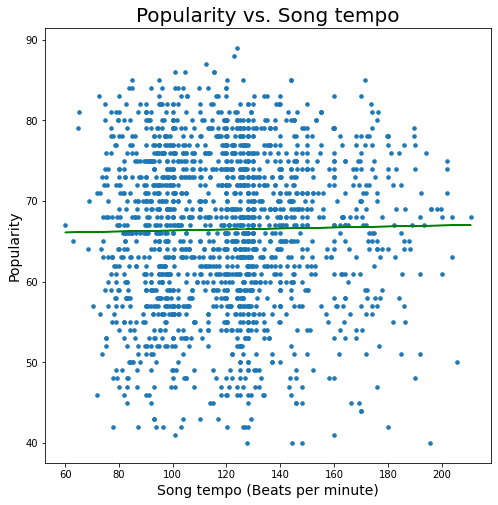

In [ ]:
plt.figure(figsize=(8, 8))
plt.xlabel("Song tempo (Beats per minute)", fontsize=14)
plt.ylabel("Popularity", fontsize=14)
plt.title("Popularity vs. Song tempo", fontsize=20)

xs = songsdata["tempo"]
ys = songsdata["popularity"]

plt.scatter(xs, ys, marker=".", s=50)
b, m = polyfit(xs, ys, 1)
plt.plot(xs, b + m * xs, 'g');

Our visualization demonstrates a few important insights. Directly addressing our intial hypothesis, there is no strong statistical correlation between tempo and popularity within our dataset. In a practical sense, we could imagine songs with gratuitously fast or slow beats would be pretty unpalatable to the average music listener, but within the most common tempo range, a song's popularity seems largely unaffected by the beats per music.

The visualzation also shows the modality of song tempos, with dense regions around 125 and 95 BPM. 

Based on our findings, we can **reject** the hypothesis that there is a statistically significant correlation between Popularity and Song tempo.

## Valence vs Release year

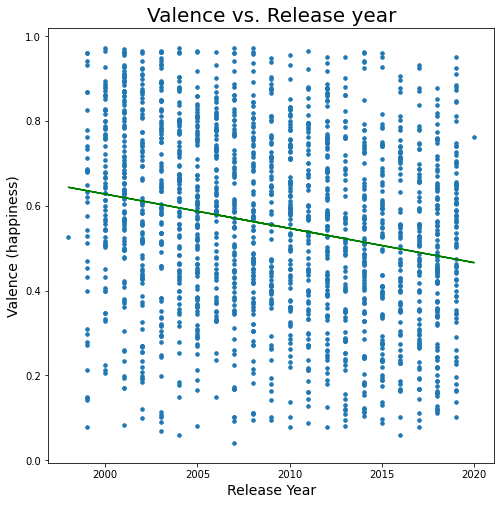

In [ ]:
plt.figure(figsize=(8, 8))
plt.xlabel("Release Year", fontsize=14)
plt.ylabel("Valence (happiness)", fontsize=14)
plt.title("Valence vs. Release year", fontsize=20)

xs2 = songsdata["year"]
ys2 = songsdata["valence"]

plt.scatter(xs2, ys2, marker=".", s=50)
b, m = polyfit(xs2, ys2, 1)
plt.plot(xs2, b + m * xs2, 'g');

Our scatterplot visualization shows us that there is a significant negative correlation between release year and Valence. Popular music, indeed has gotten less cheery since the late-1990s. 

We can see interesting trends in the corners of our scatterplot-- since 2000, the number of exceptionally happy songs has dramatically decreased, which can be observed in the upper-right corner. Similarly, the number of exceptionally sad songs has increased in the same time.  

Based on our findings, we can **accept** the hypothesis that there is a statistically significant negative correlation between Valence and Release year.

## Correlation Matrix

Though not one of my original hypotheses, I grew interested in the correlations between the rest of the attributes. I regrettably couldn't get Matplotlib's heatmap function to reliably work, but would very much like to strive toward that goal in the near future. 

I use pandas correlation matrix call here, and round the results to two decimal places to keep it neat.

In [ ]:
cormat = frame.corr()
round(cormat,2)

,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
duration_ms,1.00,0.12,-0.31,-0.09,-0.04,-0.06,-0.00,-0.08,-0.02,0.08,0.01,0.01,0.02,-0.11,-0.02
explicit,0.12,1.00,0.08,0.05,0.26,-0.16,0.00,-0.08,0.06,0.42,-0.03,-0.08,0.01,-0.04,0.01
year,-0.31,0.08,1.00,0.33,0.03,-0.12,0.02,0.02,-0.00,0.00,0.04,-0.06,-0.03,-0.22,0.06
popularity,-0.09,0.05,0.33,1.00,-0.01,-0.09,-0.01,0.02,0.01,-0.02,0.08,-0.05,-0.03,-0.10,0.02
danceability,-0.04,0.26,0.03,-0.01,1.00,-0.12,0.03,-0.04,-0.06,0.15,-0.05,0.02,-0.13,0.40,-0.19
energy,-0.06,-0.16,-0.12,-0.09,-0.12,1.00,0.00,0.65,-0.05,-0.06,-0.45,0.05,0.16,0.33,0.15
key,-0.00,0.00,0.02,-0.01,0.03,0.00,1.00,-0.00,-0.15,0.02,0.00,-0.00,-0.03,0.04,0.01
loudness,-0.08,-0.08,0.02,0.02,-0.04,0.65,-0.00,1.00,-0.03,-0.08,-0.31,-0.09,0.11,0.22,0.08
mode,-0.02,0.06,-0.00,0.01,-0.06,-0.05,-0.15,-0.03,1.00,-0.01,-0.01,-0.05,0.02,-0.08,0.04
speechiness,0.08,0.42,0.00,-0.02,0.15,-0.06,0.02,-0.08,-0.01,1.00,0.00,-0.06,0.05,0.07,0.05
